In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import recommendations
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
df = pd.read_csv('../datasets/processed_dataset.csv')
df = df[['Student Number', 'Course Code', 'Letter Grade', 'Semester', 'Course Credit']]
df

,Student Number,Course Code,Letter Grade,Semester,Course Credit
0,1182,MGT 511,A-,2011 - Fall,3
1,134,UNI 123,C-,2011 - Fall,3
2,217,UNI 115,A-,2011 - Fall,3
3,1227,MGT 511,B,2011 - Fall,3
4,1225,MGT 541,B+,2011 - Fall,3
...,...,...,...,...,...
49342,1311,EECS 216,F,2014 - Spring,3
49343,1311,EECS 202,D+,2014 - Spring,3
49344,1311,EECS 218,B-,2014 - Spring,3
49345,173,CTV 212,C+,2014 - Spring,3


In [3]:
numerical_grades = {'A+': 4.1, 'A': 4.0, 'A-': 3.7, 'B+': 3.3, 'B': 3.0, 'B-': 2.7, 'C+': 2.3, 'C': 2.0,
                    'C-': 1.7, 'D+': 1.3, 'D': 1.0, 'D-': 0.5, 'F': 0.0}

In [4]:
semester_data = {}
course_credits = {}
for row_idx in df.index:
    student_number = df.iloc[row_idx, 0]
    course_code = df.iloc[row_idx, 1]
    letter_grade = df.iloc[row_idx, 2]
    semester = df.iloc[row_idx, 3]
    credit = df.iloc[row_idx, 4]
    
    course_credits[course_code] = credit
    semester_data.setdefault(semester, {})
    semester_data[semester].setdefault(student_number, {})
    semester_data[semester][student_number][course_code] = numerical_grades[letter_grade]

In order to assess the accuracy of the model, we use Root Mean Squared Error (RMSE) which is defined as: 

$$\large \text{RMSE}(y, \hat{y}) = \sqrt{\frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2}$$


The mean_absolute_error function computes mean absolute error, a risk metric corresponding to the expected value of the absolute error loss or $l$1-norm loss. If $\hat{y}_i$ is the predicted value of the $i$-th sample, and $y_i$ is the corresponding true value, then the mean absolute error (MAE) estimated over $n_{\text{samples}}$ is defined as:

$$\large \text{MAE}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1} \left| y_i - \hat{y}_i \right|$$

In [5]:
def get_avg_gpa(train_semester, student):
    courses = train_semester[student]
    total_credit = 0
    weights = 0
    for course in courses:
        total_credit += course_credits[course]
        weights += courses[course] * course_credits[course]
    
    return weights / total_credit

In [6]:
def get_errors(train_semester, test_semester, sim):
    average_gpa = {}
    y_true = []
    y_pred = []
    
    for student in train_semester:
        recommended_courses = {}
        recs = recommendations.getRecommendations(train_semester, student, sim)
        for rec_grade, rec_course in recs:
            recommended_courses.setdefault(rec_course, rec_grade)
        average_gpa.setdefault(student, get_avg_gpa(train_semester, student))
        
        if student not in test_semester:
            continue
            
        for course_code in test_semester[student]:
            y_true.append(test_semester[student][course_code])
            if course_code in recommended_courses:
                y_pred.append(recommended_courses[course_code])
            else:
                y_pred.append(average_gpa[student])
        
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    return rmse, mae

In [7]:
def predict(semester_data, sim):
    errors = {'rmse': [], 'mae': []}
    train_semester = {}
    for i in range(1, len(sorted(semester_data))):
        new_semester = semester_data[sorted(semester_data)[i-1]]
        for student in new_semester:
            if student in train_semester:
                train_semester[student].update(new_semester[student])
            else:
                train_semester[student] = new_semester[student]
        test_semester = semester_data[sorted(semester_data)[i]]

        # making predictions for every student in training semester
        rmse, mae = get_errors(train_semester, test_semester, sim)

        errors['rmse'].append(rmse)
        errors['mae'].append(mae)
    
    return errors

In [8]:
def plot_errors(errors, sim):
    x = np.arange(7)
    fig, ax = plt.subplots(figsize=(11, 5.5))
    rects1 = ax.bar(x - 0.35/2, errors['rmse'], 0.35, label='RMSE')
    rects2 = ax.bar(x + 0.35/2, errors['mae'], 0.35, label='MAE')
    for i, v in enumerate(errors['rmse']):
        ax.text(i-0.36, v + 0.01, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold')
    for i, v in enumerate(errors['mae']):
        ax.text(i-0.01, v + 0.01, str(round(v, 2)), fontfamily='serif', fontsize=13, fontweight='bold')
    ax.set_ylabel('Error', fontsize=22, fontfamily='serif')
    ax.set_title('Error Metrics with N training semesters ({})'.format(sim), fontsize=22, fontfamily='serif')
    ax.set_xticks(x)
    ax.set_xticklabels(['N={}'.format(i+1) for i in range(7)], fontsize=22, fontfamily='serif')
    ax.set_yticklabels([round(i,1) for i in ax.get_yticks()], fontsize=22, fontfamily='serif')
    ax.tick_params(labelsize=22)
    ax.grid(True)
    ax.legend(prop={'size': 18, 'family': 'serif'}, loc='center', bbox_to_anchor=(0.5, -0.15), ncol=2)

The euclidean distance between all points $p$ and $q$ are given by:

$$\large d\left( p,q\right)   = \sqrt {\sum _{i=1}^{n}  \left( q_{i}-p_{i}\right)^2 }$$

where d( $p$,$q$ ) is 0 when $p$ = $q$. In order to show a high numerical value for close points, we make the following division:

$$\large d\left( p,q\right)   = \frac{1}{1 + d\left( p,q\right)}$$

In [9]:
results = {}

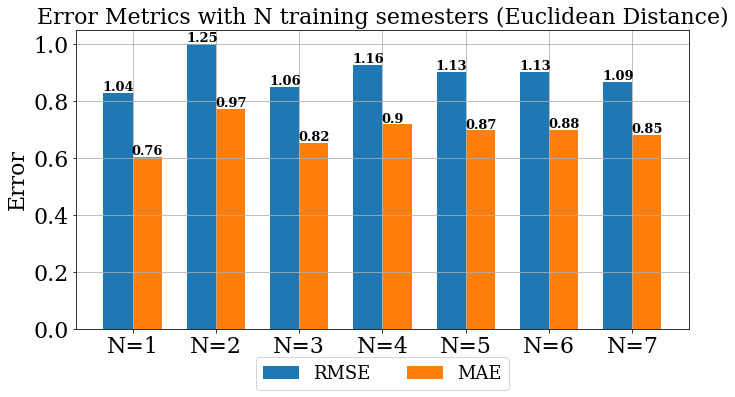

In [10]:
errors = predict(semester_data, recommendations.sim_distance)
results['Euclidean Distance'] = errors
plot_errors(errors, 'Euclidean Distance')

The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient, is a statistic used for gauging the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

$$\large J(A,B) = \frac{|A \cap B|}{|A \cup B|}$$

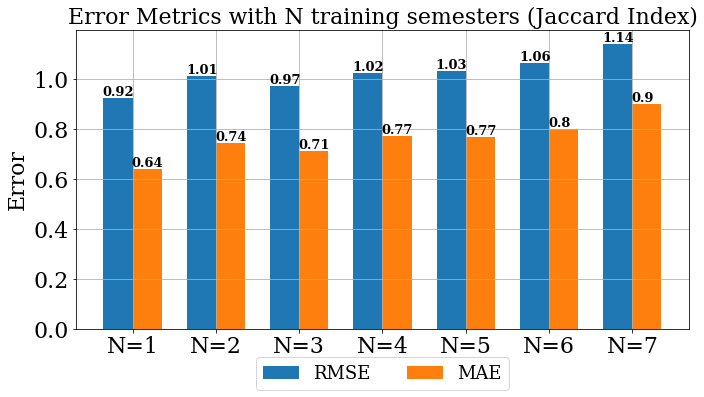

In [11]:
errors = predict(semester_data, recommendations.sim_jaccard)
results['Jaccard Index'] = errors
plot_errors(errors, 'Jaccard Index')

The correlation coefficient is a measure of how well two sets of data fit on a straight line. The formula for this is more complicated than the Euclidean distance score, but it tends to give better results in situations where the data isn’t well normalized. 


$$\large r=\frac{n(\sum xy)-(\sum x)(\sum y)}{\sqrt{[n\sum x^{2}-(\sum x)^{2}][n\sum y^{2}-(\sum y)^{2}]}}$$

where $x$ corresponds to values in the first set of data and $y$ corresponds to the other one. $n$ determines the total number of samples.

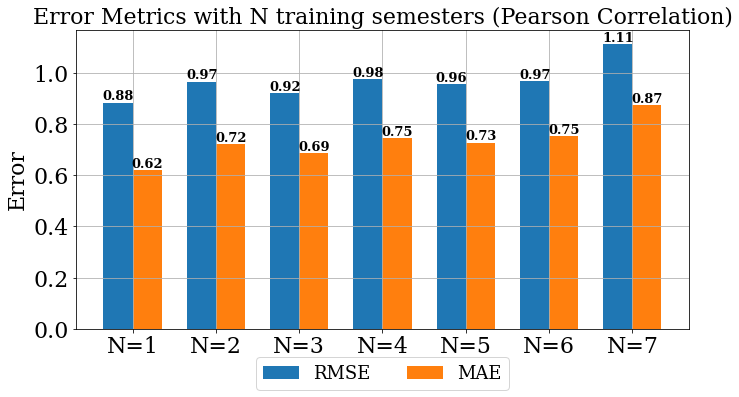

In [12]:
errors = predict(semester_data, recommendations.sim_pearson)
results['Pearson Correlation'] = errors
plot_errors(errors, 'Pearson Correlation')

In [13]:
import json
with open('baseline_collaborative_filtering_results.json', 'w') as fw:
    json.dump(results, fw)